## Data Preprocessing

In [2]:
##import packages here
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [3]:
import xgboost

## Nasdaq Composite Index since 1971

In [4]:
##import prices from NASDAQ-all-time-daily.csv
##has data since 2/5/71
nasdaq_df = pd.read_csv('data/NASDAQ-all-time-daily.csv')
# nasdaq_df = pd.read_csv('NASDAQ-all-time-daily.csv',parse_dates = True, index_col = 0)
## index_col = 0 removes the first colum of indexs 0,1,2.... otherwise the plot below 
## will not appear as years 
##drop NaN rows
nasdaq_df.dropna()
##no need to drop more rows

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...
12670,2021-05-03,14031.769531,14042.120117,13881.509766,13895.120117,13895.120117,4718850000
12671,2021-05-04,13774.509766,13795.570313,13485.589844,13633.500000,13633.500000,5852850000
12672,2021-05-05,13731.129883,13753.049805,13553.929688,13582.419922,13582.419922,4517100000
12673,2021-05-06,13557.830078,13635.730469,13439.389648,13632.839844,13632.839844,5000710000


In [5]:
#describing the data
nasdaq_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,1.267500e+04
mean,1971.457402,1984.376552,1956.494959,1971.326135,1971.326135,9.876137e+08
std,2461.707310,2477.754401,2442.852852,2461.716445,2461.716445,1.108376e+09
min,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00
25%,249.004998,249.215004,248.875000,249.130005,249.130005,0.000000e+00
50%,1085.119995,1092.260010,1080.650024,1087.219971,1087.219971,4.898600e+08
75%,2544.799927,2564.794921,2519.655029,2544.289917,2544.289917,1.844120e+09
max,14204.509766,14211.570313,14064.280273,14138.780273,14138.780273,1.110216e+10


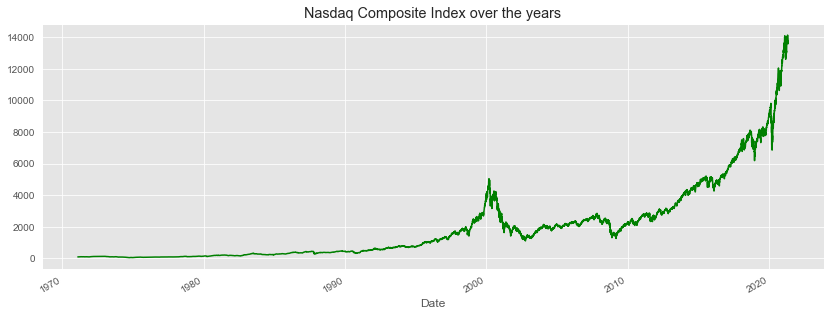

In [8]:
#plot 
style.use('ggplot')
plt.figure(figsize = (14,5))
nasplot = pd.read_csv('data/NASDAQ-all-time-daily.csv', parse_dates = True, index_col = 0)
nasplot['Adj Close'].plot(c='g')
#plt.xlabel('')
plt.title('Nasdaq Composite Index over the years')
plt.show()

## 10-year treasury bond rate yield

In [10]:
##import bond yield from 10-year-treasury-bond-rate-yield-chart.csv
##has data since 1962
file_bond = open('data/10-year-treasury-bond-rate-yield-chart.csv')
bond_df = pd.read_csv(file_bond, names=['date', 'value'])
file_bond.close()

##drop NaN rows
bond_df = bond_df.dropna()
##drop header rows
bond_df = bond_df[1:]

bond_df

,date,value
9,1962-01-02,4.0600
10,1962-01-03,4.0300
11,1962-01-04,3.9900
12,1962-01-05,4.0200
13,1962-01-08,4.0300
...,...,...
14844,2021-04-30,1.6500
14845,2021-05-03,1.6300
14846,2021-05-04,1.6100
14847,2021-05-05,1.5900


In [ ]:
##put all the data in one data frame
##columns: 'date', 'open', 'close', 'high', 'low', 'pe', 'bond'


### Daily Returns of Nasdaq

In [11]:
# Get `Adj Close` and assign to `daily_close`
daily_close = nasdaq_df['Adj Close']

# Daily returns percentage change
nasdaq_df['Return'] = 100 * (nasdaq_df['Adj Close'].pct_change())

# Rounding the change to 2 digits after decimal
daily_pct_chg = round(nasdaq_df['Return'],2)

# Print `daily_pct_c`
daily_pct_chg.head(10)

0     NaN
1    0.84
2   -0.08
3   -0.07
4    0.75
5    0.59
6    0.14
7   -0.44
8   -0.31
9   -0.71
Name: Return, dtype: float64

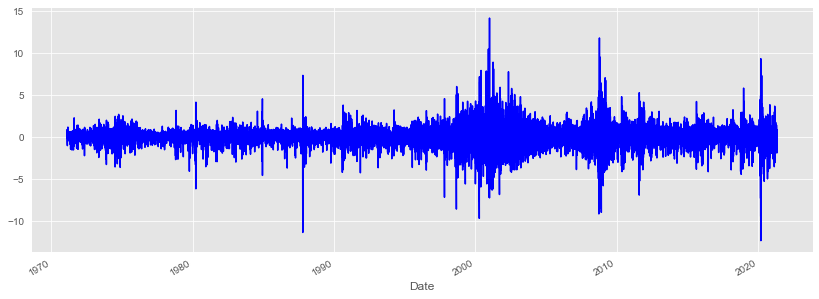

In [12]:
#plot
plt.figure(figsize = (14,5))
nasplot['Return'] = 100 * (nasplot['Adj Close'].pct_change())
# Rounding the change to 2 digits after decimal
daily_pct_chg = round(nasplot['Return'],2)
nasplot['Return'].plot(color = 'b')
plt.show()

## Facebook Prophet

In [13]:
# Defining proper training and test data sets
train_size = int(nasdaq_df.shape[0]*0.85)
train_df = nasdaq_df.iloc[:train_size]
test_df = nasdaq_df.iloc[train_size+1:]

In [14]:
# Building model using fbprophet
import fbprophet as prophet
# reset index to get date_time as a column
prophet_df = train_df[['Date','Adj Close']]

# prepare the required dataframe
prophet_df.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
prophet_df.ds = pd.to_datetime(prophet_df.ds)

prophet_df = prophet_df[['ds','y']]

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
# Prophet model
pro_model = prophet.Prophet()
pro_model.fit(prophet_df)
#Create future dataframe
test_dates = pro_model.make_future_dataframe(periods=test_df.shape[0])
#Forecast the data using the model
forecast_df = pro_model.predict(test_dates)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


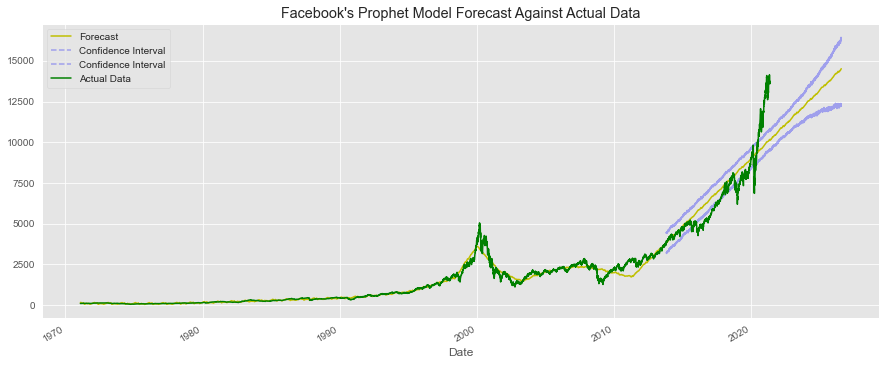

In [16]:
# Plot the forecasted data and current data  
forecast_df['datetime'] = forecast_df['ds']
forecast_df.set_index('datetime', inplace=True)
fig, ax = plt.subplots(figsize=(15, 6))
# plot against true data
plt.plot(forecast_df.yhat,c='y',label='Forecast')
plt.plot(forecast_df.yhat_lower.iloc[train_size+1:], 
         linestyle='--',
         c='b',
         alpha=0.3,
         label='Confidence Interval')
plt.plot(forecast_df.yhat_upper.iloc[train_size+1:],
         linestyle='--',
         c='b',
         alpha=0.3,
label='Confidence Interval')
#plt.plot(prophet_df.y,c='g',label='Actual Data')
nasplot = pd.read_csv('data/NASDAQ-all-time-daily.csv', parse_dates = True, index_col = 0)
nasplot['Adj Close'].plot(c = 'g', label='Actual Data')
plt.legend()
plt.title('Facebook\'s Prophet Model Forecast Against Actual Data')
plt.show()

In [1]:
print(test_dates)

NameError: name 'test_dates' is not defined